# First experiment: awake / asleep


Epoch 1/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7046 - loss: 0.1953 - val_accuracy: 0.8789 - val_loss: 0.0925
Epoch 2/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8809 - loss: 0.0909 - val_accuracy: 0.8840 - val_loss: 0.0871
Epoch 3/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8841 - loss: 0.0864 - val_accuracy: 0.8846 - val_loss: 0.0862
Epoch 4/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8849 - loss: 0.0863 - val_accuracy: 0.8850 - val_loss: 0.0862
Epoch 5/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8833 - loss: 0.0880 - val_accuracy: 0.8853 - val_loss: 0.0861
Epoch 6/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8868 - loss: 0.0842 - val_accuracy: 0.8858 - val_loss: 0.0862
Epoch 7/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8860 - loss: 0.0851 - val_accuracy: 0.8841 - val_loss: 0.0866
Epoch 8/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8845 - loss: 0.0869 - val_accuracy: 0

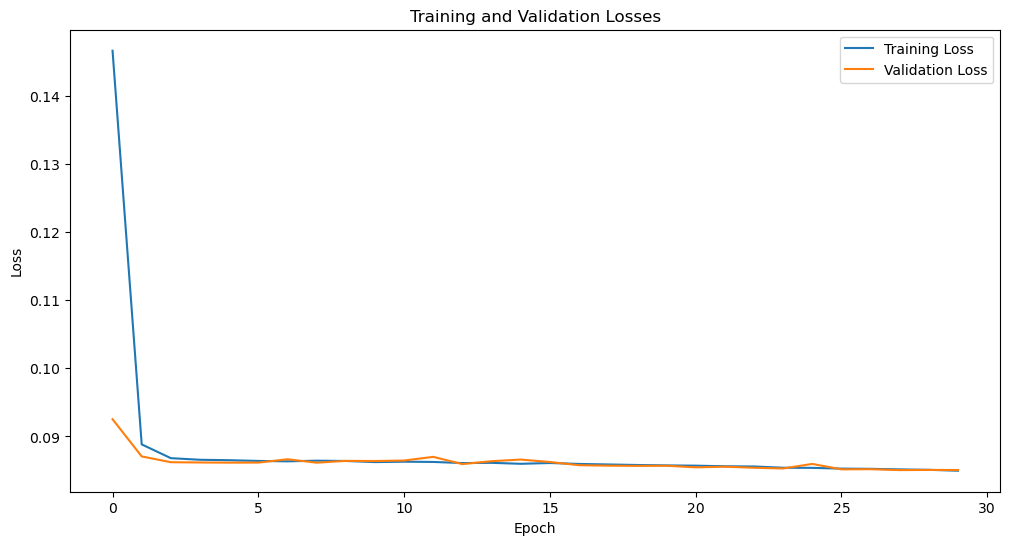

426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Confusion Matrix:


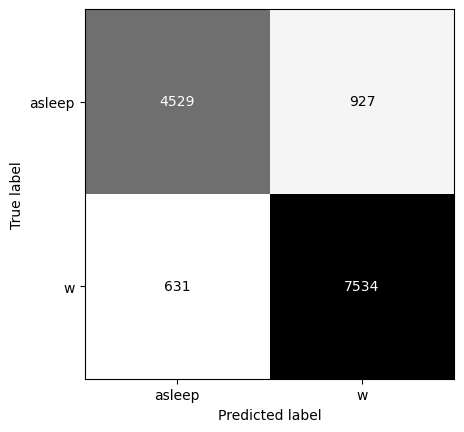

F1 Score per class:  [0.85324039 0.90629135]
Micro F1 Score:  0.8856177960502166
Epoch 1/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8853 - loss: 0.0849 - val_accuracy: 0.8888 - val_loss: 0.0845
Epoch 2/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8848 - loss: 0.0859 - val_accuracy: 0.8897 - val_loss: 0.0839
Epoch 3/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8861 - loss: 0.0845 - val_accuracy: 0.8869 - val_loss: 0.0847
Epoch 4/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8853 - loss: 0.0852 - val_accuracy: 0.8900 - val_loss: 0.0837
Epoch 5/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8849 - loss: 0.0855 - val_accuracy: 0.8899 - val_loss: 0.0837
Epoch 6/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8872 - loss: 0.0839 - val_accuracy: 0.8894 - val_loss: 0.0839
Epoch 7/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8865 - loss: 0.0846 - val_accuracy: 0.8896 - val_loss: 0.0836
Epoch 8/30
852/852 ━━

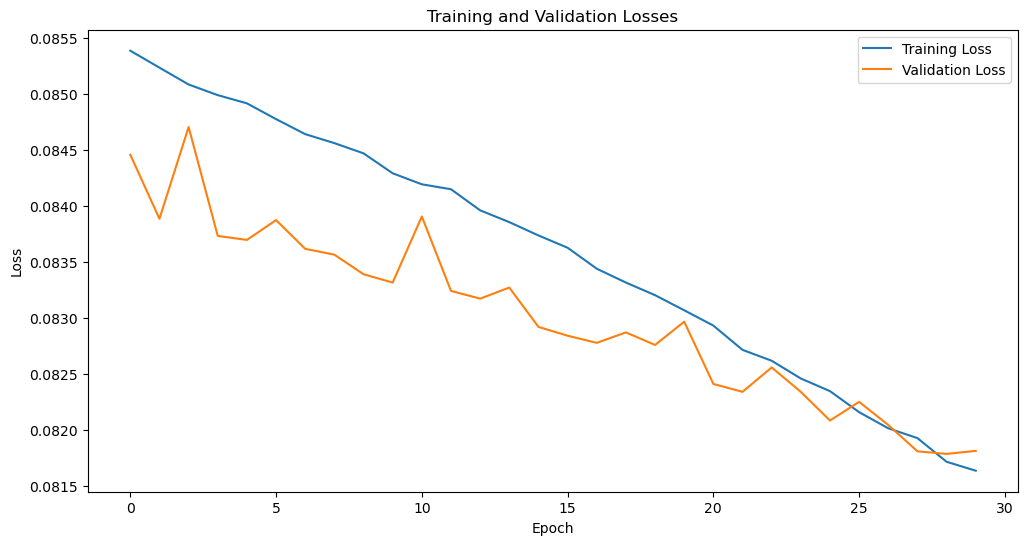

426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Confusion Matrix:


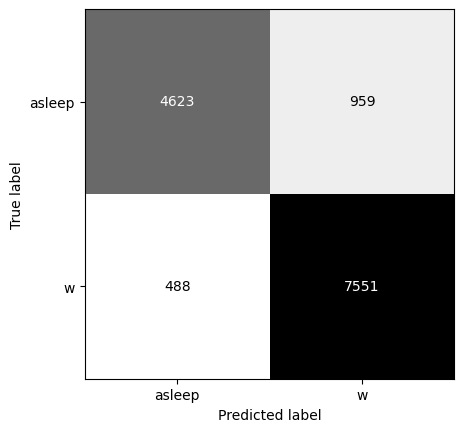

F1 Score per class:  [0.86467783 0.91256269]
Micro F1 Score:  0.893766977461273
Epoch 1/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8904 - loss: 0.0831 - val_accuracy: 0.8901 - val_loss: 0.0818
Epoch 2/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8923 - loss: 0.0820 - val_accuracy: 0.8899 - val_loss: 0.0820
Epoch 3/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8954 - loss: 0.0799 - val_accuracy: 0.8895 - val_loss: 0.0819
Epoch 4/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8937 - loss: 0.0816 - val_accuracy: 0.8894 - val_loss: 0.0817
Epoch 5/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8956 - loss: 0.0796 - val_accuracy: 0.8897 - val_loss: 0.0818
Epoch 6/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8948 - loss: 0.0793 - val_accuracy: 0.8906 - val_loss: 0.0819
Epoch 7/30
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8971 - loss: 0.0782 - val_accuracy: 0.8910 - val_loss: 0.0819
Epoch 8/30
852/852 ━━━━

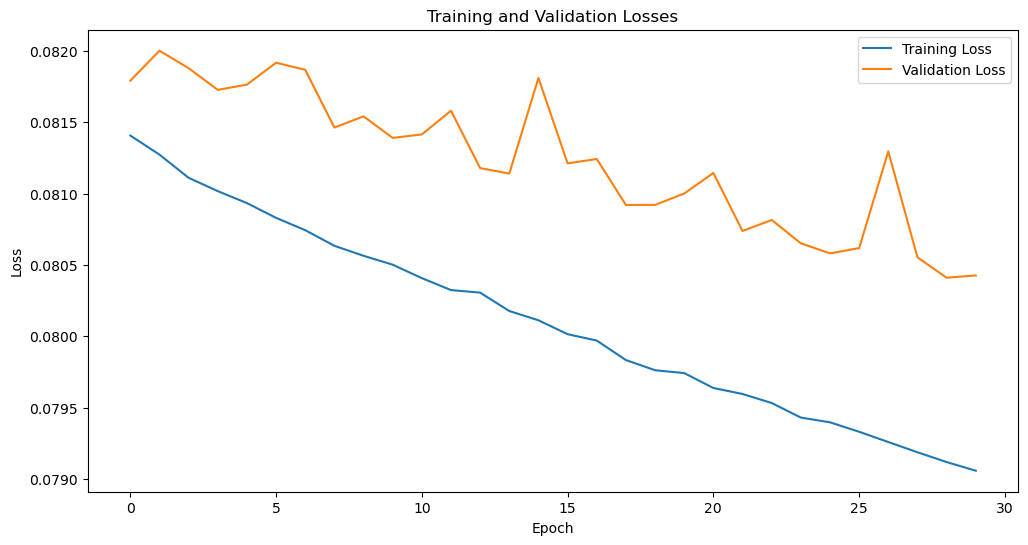

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:


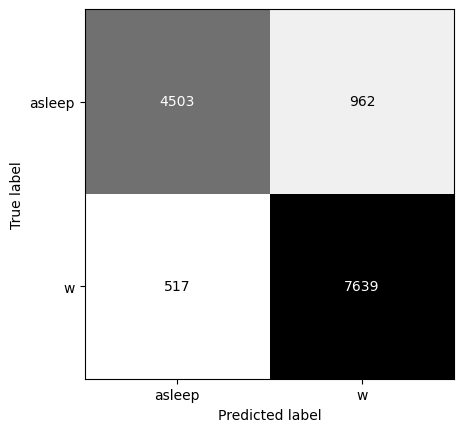

F1 Score per class:  [0.85894134 0.91173838]
Micro F1 Score:  0.8914176639013288
2504/2504 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,621 (29.77 KB)

 Trainable params: 3,810 (14.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,811 (14.89 KB)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from keras.optimizers import SGD

# Load the data
data_1 = pd.read_csv('EEG_mouse_data_1.csv')
data_2 = pd.read_csv('EEG_mouse_data_2.csv')
data = pd.concat([data_1, data_2])

# Preprocess the data
features = data.columns[1:26]  # Select 25 features
X = data[features].values
y = data['state'].values  # Target variable

# Group 'n-rem' and 'rem' into 'asleep'
y = data['state'].replace(['n', 'r'], 'asleep').values


# Convert labels to integer values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert integer labels to categorical
y = to_categorical(y)

# Define the MLP model
model = Sequential()
model.add(Input(shape=(25,))) # Input layer with 25 features
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Number of neurons equals number of classes

# Define your learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

# Pass the learning rate to the optimizer
sgd = SGD(learning_rate=lr_schedule, momentum=0.5)

model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

# Use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_val = scaler.transform(X_val)  # Transform the validation data

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_val)
    
    print('Confusion Matrix:\n')
    # Compute confusion matrix
    cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

    # Create ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    # Plot confusion matrix with black text
    disp.plot(cmap='binary', colorbar=False, values_format='d')
    plt.show()
        
    confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
    
    f1_scores_per_class = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average=None)
    f1_score_micro = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro')

    print('F1 Score per class: ', f1_scores_per_class)
    print('Micro F1 Score: ', f1_score_micro)
    
# Save the model's predictions on the test set
test_data = pd.read_csv('EEG_mouse_data_test.csv')
X_test = test_data[features].values  # Use the same features as the training data
X_test = scaler.transform(X_test)  # Use the same scaler fitted on the last training fold
test_predictions = model.predict(X_test)

model.summary()


with open('test_pred.npy', 'wb') as f:
    np.save(f, test_predictions.argmax(axis=1))

# Second experiment: awake / n-rem / rem

Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8442 - loss: 0.4371 - val_accuracy: 0.8720 - val_loss: 0.3701
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8702 - loss: 0.3621 - val_accuracy: 0.8711 - val_loss: 0.3683
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8683 - loss: 0.3629 - val_accuracy: 0.8704 - val_loss: 0.3690
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8676 - loss: 0.3648 - val_accuracy: 0.8701 - val_loss: 0.3664
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8713 - loss: 0.3582 - val_accuracy: 0.8713 - val_loss: 0.3675
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8687 - loss: 0.3626 - val_accuracy: 0.8717 - val_loss: 0.3675
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8679 - loss: 0.3607 - val_accuracy: 0.8737 - val_loss: 0.3671
Epoch 8/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8671 - loss: 0.3632 - val_accuracy: 0.

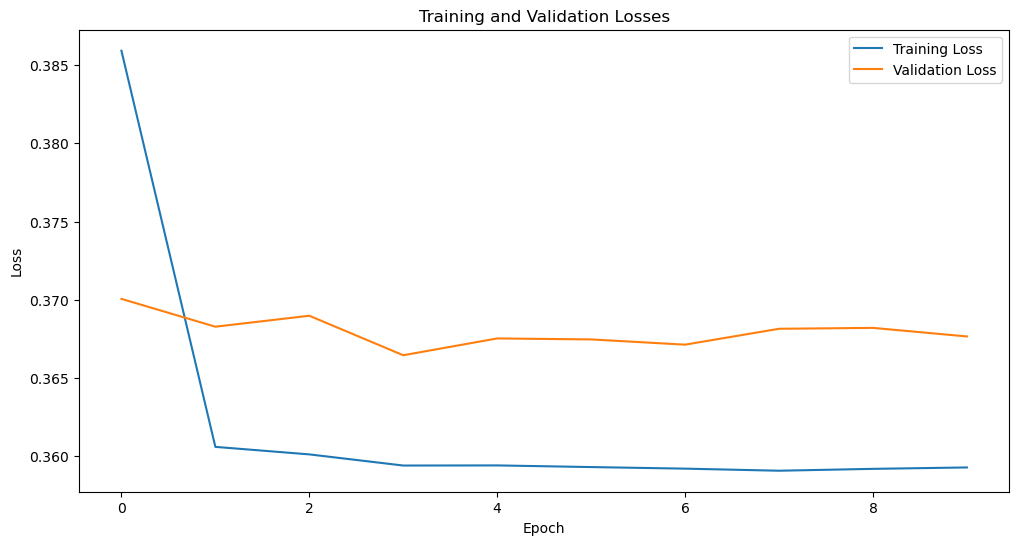

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
 [[3857   50  580]
 [ 121  317  520]
 [ 388  104 7684]]
F1 Score per class:  [0.87134305 0.4436669  0.90613208]
Micro F1 Score:  0.870567506056824
Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8717 - loss: 0.3535 - val_accuracy: 0.8665 - val_loss: 0.3680
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8712 - loss: 0.3591 - val_accuracy: 0.8646 - val_loss: 0.3679
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8735 - loss: 0.3548 - val_accuracy: 0.8658 - val_loss: 0.3673
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8729 - loss: 0.3590 - val_accuracy: 0.8646 - val_loss: 0.3678
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8733 - loss: 0.3577 - val_accuracy: 0.8666 - val_loss: 0.3670
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8768 - loss: 0.3522 - val_accuracy: 0.8657 - val_loss: 0.3671
Epoch 7/10
852/852 ━━━━━━━

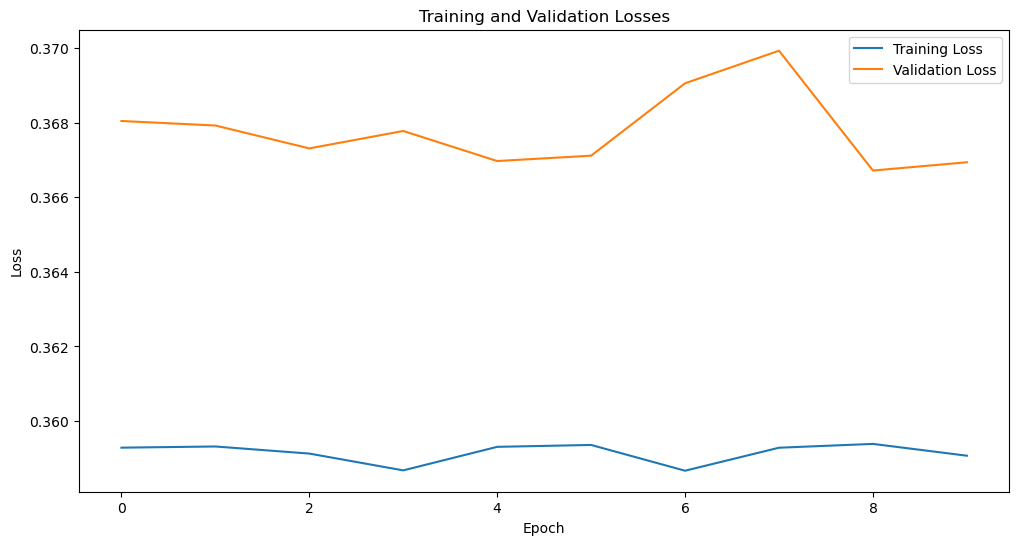

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
 [[3885   47  689]
 [ 123  299  541]
 [ 334   84 7619]]
F1 Score per class:  [0.86689724 0.4292893  0.90240436]
Micro F1 Score:  0.86652962337567
Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8693 - loss: 0.3636 - val_accuracy: 0.8734 - val_loss: 0.3507
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8722 - loss: 0.3594 - val_accuracy: 0.8730 - val_loss: 0.3521
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8696 - loss: 0.3691 - val_accuracy: 0.8734 - val_loss: 0.3517
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8683 - loss: 0.3668 - val_accuracy: 0.8734 - val_loss: 0.3517
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8688 - loss: 0.3647 - val_accuracy: 0.8731 - val_loss: 0.3510
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8702 - loss: 0.3637 - val_accuracy: 0.8739 - val_loss: 0.3512
Epoch 7/10
852/852 ━━━━━━━━

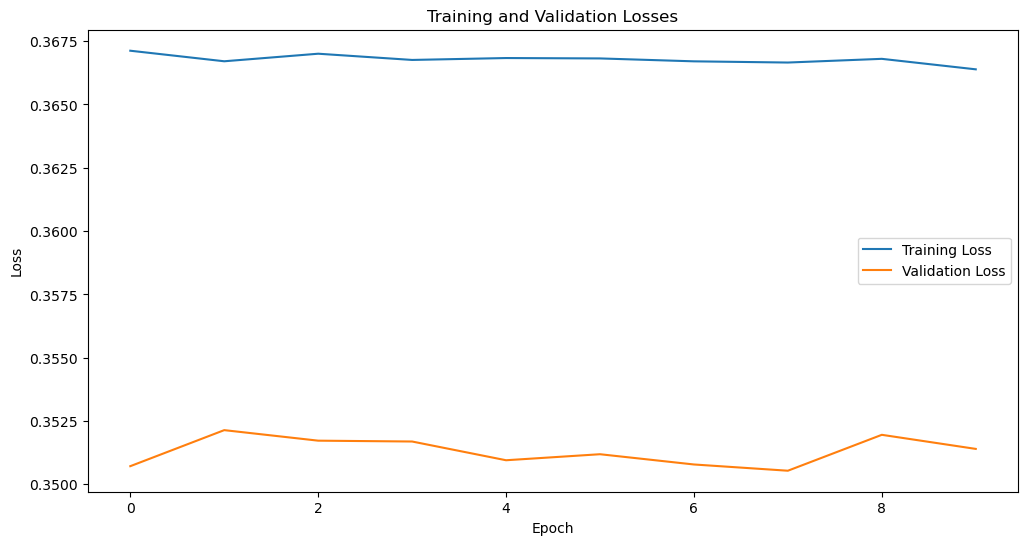

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
 [[3881   63  612]
 [ 107  320  491]
 [ 334   99 7714]]
F1 Score per class:  [0.87429601 0.45714286 0.90945532]
Micro F1 Score:  0.8747522208354747
2504/2504 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79 (320.00 B)

 Trainable params: 78 (312.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1 (8.00 B)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from keras.optimizers import SGD

# Load the data
data_1 = pd.read_csv('EEG_mouse_data_1.csv')
data_2 = pd.read_csv('EEG_mouse_data_2.csv')
data = pd.concat([data_1, data_2])

# Preprocess the data
features = data.columns[1:26]  # Select 25 features
X = data[features].values
y = data['state'].values  # Target variable



# Convert labels to integer values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert integer labels to categorical
y = to_categorical(y)

# Define the MLP model
model = Sequential()
model.add(Input(shape=(25,))) # Input layer with 25 features

model.add(Dense(y.shape[1], activation='sigmoid'))  # Number of neurons equals number of classes

# Define your learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

# Pass the learning rate to the optimizer
sgd = SGD(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_val = scaler.transform(X_val)  # Transform the validation data

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_val)
    
    print('Confusion Matrix:\n', confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
    
    f1_scores_per_class = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average=None)
    f1_score_micro = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro')

    print('F1 Score per class: ', f1_scores_per_class)
    print('Micro F1 Score: ', f1_score_micro)
    
# Save the model's predictions on the test set
test_data = pd.read_csv('EEG_mouse_data_test.csv')
X_test = test_data[features].values  # Use the same features as the training data
X_test = scaler.transform(X_test)  # Use the same scaler fitted on the last training fold
test_predictions = model.predict(X_test)

model.summary()


with open('test_pred.npy', 'wb') as f:
    np.save(f, test_predictions.argmax(axis=1))